# Обработка отчета SLA.

Писалась для использования через Google Colab, чтобы не затрачивать время ИТ на установку ПО или предоставление доступов.

In [ ]:
#@title Загрузка файла SLA. Перед загрузкой удали уже скаченный файл из директории.
from google.colab import files
sla = files.upload()

Saving SLA.xlsx to SLA.xlsx


In [ ]:
#@title Подключение библиотек. Создание DataFrame.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
correction = pd.read_excel('/content/SLA.xlsx', sheet_name='correction') 
pretension = pd.read_excel('/content/SLA.xlsx', sheet_name='pretension') 
rtu = pd.read_excel('/content/SLA.xlsx', sheet_name='rtu')

In [ ]:
#@title Предобработка данных
pretension = pretension.rename(
    columns={'Акт.Дата.Год': 'Год', 'Акт.Дата.Месяц': 'Месяц', 'Акт.Дата.Неделя года': 'Неделя_года'
             , 'Акт.Дата.День': 'День', 'Акт.Дата.День недели': 'День_недели', 'Количество строк': 'Строк'})
rtu = rtu.rename(
    columns={'День распечатки.Год': 'Год', 'День распечатки.Месяц': 'Месяц', 'Вес (факт), кг': 'Вес_кг', 
             'Объем (факт), м3': 'Объем_ м3', 'Количество строк': 'Строк'})
correction = correction.dropna(subset=['Документ'])

correction['вычерков'] = 1
date = ['Год', 'Месяц', 'День', 'День недели', 'Неделя года']
for d in date:
    correction[d] = correction[d].astype('int')
correction.columns = correction.columns.str.lower().str.replace(' ', '_')
pretension.columns = pretension.columns.str.lower().str.replace(' ', '_')
rtu.columns = rtu.columns.str.lower().str.replace(' ', '_')
correction['документ'] = correction['документ'].astype('str')
rtu = rtu.drop('сумма', axis=1)

In [ ]:
#@title Создание сводных по претензиям и вычеркам
pivot_pr = (pretension
            .pivot_table(values=['строк', 'количество_актов'], index=['год','месяц'], aggfunc='sum')
            .reset_index()
           )
pivot_pr = pivot_pr.rename(columns={'строк':'строк_претензий'})


correction['рту_вычерк'] = np.where((correction['документ'].duplicated() == False), 1, 0)
pivot_cr = correction.pivot_table(values=['вычерков','рту_вычерк'], index=['год', 'месяц'], aggfunc='sum').reset_index()

In [ ]:
#@title Создание общей таблицы с показателями
df = rtu.merge(pivot_pr, on=['год', 'месяц'], how='left')
df = df.merge(pivot_cr, on=['год', 'месяц'], how='left')
df = df.fillna('0')
type_int = ['строк', 'рту', 'количество_актов', 'строк_претензий', 'вычерков', 'рту_вычерк']
for c in type_int:
    df[c] = df[c].astype('int')

In [ ]:
#@title Расчет коэффициентов
df['koef_вычерков_стр'] = (df['вычерков']/df['строк']*100).round(2)
df['koef_вычерков_рту'] = (df['рту_вычерк']/df['рту']*100).round(2)
df['koef_претензий_стр'] = (df['строк_претензий']/df['строк']*100).round(2)
df['koef_претензий_рту'] = (df['количество_актов']/df['рту']*100).round(2)
df['koef_рту_идеал'] = (100-df['koef_вычерков_рту']-df['koef_претензий_рту']).round(2)
df = df.sort_values(by=['год', 'месяц'])

In [ ]:
#@title вывод основных данных
df = df.sort_values(by=['год', 'месяц'])
df[['год', 'месяц', 'рту', 'строк', 'количество_актов', 'строк_претензий', 'вычерков', 'рту_вычерк', 
    'koef_вычерков_стр', 'koef_вычерков_рту', 'koef_претензий_стр', 'koef_претензий_рту', 'koef_рту_идеал']].tail(6)

,год,месяц,рту,строк,количество_актов,строк_претензий,вычерков,рту_вычерк,koef_вычерков_стр,koef_вычерков_рту,koef_претензий_стр,koef_претензий_рту,koef_рту_идеал
28,2022,5,95272,722643,1037,1725,1041,962,0.14,1.01,0.24,1.09,97.90
29,2022,6,103804,753033,1011,1709,766,714,0.10,0.69,0.23,0.97,98.34
30,2022,7,109681,780523,1012,1655,725,671,0.09,0.61,0.21,0.92,98.47
31,2022,8,125434,888027,1187,2051,597,551,0.07,0.44,0.23,0.95,98.61
32,2022,9,121263,858888,940,1651,675,632,0.08,0.52,0.19,0.78,98.70
33,2022,10,88600,640499,534,623,519,482,0.08,0.54,0.10,0.60,98.86


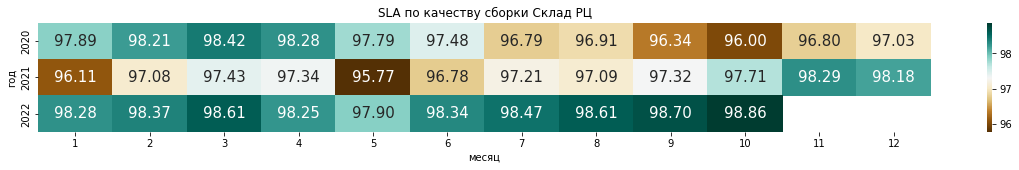

In [ ]:
#@title
plt.figure(figsize=(20, 2))
df_hetmap = sns.heatmap(df.pivot('год', 'месяц',values='koef_рту_идеал'), 
                        cmap='BrBG', annot_kws={"size": 15}, annot=True, fmt='.2f')
df_hetmap.set_title('SLA по качеству сборки Склад РЦ');

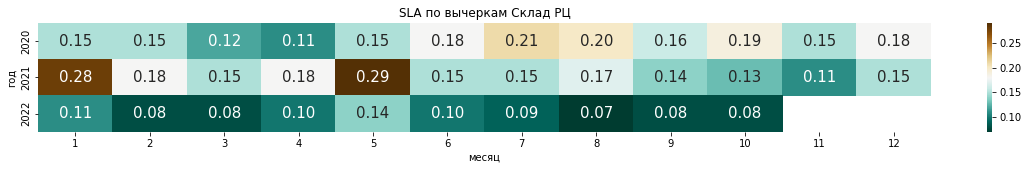

In [ ]:
#@title
plt.figure(figsize=(20, 2))
df_hetmap = sns.heatmap(df.pivot('год', 'месяц',values='koef_вычерков_стр'), 
                        cmap='BrBG_r', annot_kws={"size": 15}, annot=True, fmt='.2f')
df_hetmap.set_title('SLA по вычеркам Склад РЦ');

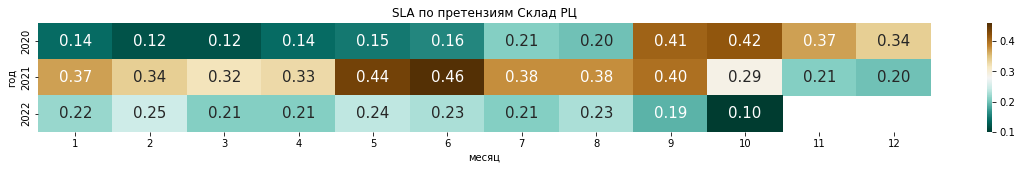

In [ ]:
#@title
plt.figure(figsize=(20, 2))
df_hetmap = sns.heatmap(df.pivot('год', 'месяц',values='koef_претензий_стр'), 
                        cmap='BrBG_r', annot_kws={"size": 15}, annot=True, fmt='.2f')
df_hetmap.set_title('SLA по претензиям Склад РЦ');

In [ ]:
#@title Выгрузка результата в Excel
(df.style.background_gradient(axis=None, cmap='RdYlGn', subset=['koef_рту_идеал'])
 .to_excel(r'/content/SLA_result.xlsx', sheet_name='SLA', index = False)
)